# Characters Degrees of Separation 

## Setup

In [3]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
import os, inspect, graphviz, pickle

In [4]:
os.listdir('../data/raw/')

['WikiCCD_2021-07-18.csv']

In [5]:
df = pd.read_csv('../data/raw/WikiCCD_2021-07-18.csv')
df = df.loc[df.index.difference([3618, 21004, 21100])]  # remove some duplicates
df = df.set_index('Component')

## get and graph vertical family trees

### get all ancestors

In [6]:
def get_all_ancestors(comp:str) -> list[str]:
    """
        INPUTS: character component as str
        OUTPUTS: list of all ancestor components
    """
    # all-ancestors stack of characters
    aa_stack = [comp]
    aa_list = [comp]
    
    while aa_stack:
        c = aa_stack.pop(0)
        
        parents = get_parents_lr(c)
        for l_r in parents:
            if parents[l_r]:
                aa_stack.append(parents[l_r])
                aa_list.append(parents[l_r])
    return aa_list

#### child functions

In [7]:
def get_parents_lr(comp:str) -> dict:
    """
        if:
            - the sub-/parent-component is different than its child, and
            - the sub-/parent-component has its own record
        then:
            - show the sub-/parent-component as the dict value,
        else:
            - show None
    """
    [lc, rc] = df.loc[comp][['LeftComponent','RightComponent']].to_list()
    
    if lc != comp:
        l = check_for_parents(lc)
    else:
        l = None
        
    if rc != comp:
        r = check_for_parents(rc)
    else:
        r = None
    
    return {'LeftComponent': l, 'RightComponent': r}

In [8]:
def get_parents(comp:str) -> list:
    return list(get_parents_lr(comp).values())

In [9]:
def check_for_parents(comp:str) -> int:
    """
        If a string is a component with its own record of parents, 
            then return that index. 
        Else,
            return None. 
    """
    try:
        return df.loc[comp].name
    except KeyError:
        return None

### get kids 

In [10]:
def get_all_descendents(comp:str) -> dict:
    """
        INPUTS: target component
        OUTPUTS: list of all descendant components
    """
    ad_stack = [comp]
    ad_list = [comp]

    while ad_stack:
        c = ad_stack.pop(0)
        kids = kdb[c]
        for kid in kids:
            ad_stack.append(kid)
            ad_list.append(kid)
    
    return ad_list

#### child functions

In [11]:
def get_kids(comp:str):
    return kdb[comp]

In [12]:
def make_kids_db() -> dict:
    """
    Create database of immediate children-components, for quick searching in that direction.
    """
    allcomps = df.index
    kids_db = {c: [] for c in allcomps}
    for c in df.index:
        comps = df.loc[c][['LeftComponent','RightComponent']].to_list()
        for xc in comps:
            try:
                kids_db[xc].append(c)
            except:
                pass
    return kids_db

### graph

In [13]:
def vertical_family_tree(comp:str='雲', directory:str='../data/processed/'):
    dot = graphviz.Digraph(comment='vertical family tree')
    aa = get_all_ancestors(comp)
    for c in aa:
        add_nodes_and_edges_parents(c, dot)

    add_nodes_and_edges_kids(comp, dot)
    
    if 'Digraph.gv.pdf' in os.listdir(directory):
        os.remove(directory + 'Digraph.gv.pdf')
    filename = dot.render(format='pdf', directory=directory)
    
    return dot

In [14]:
def add_nodes_and_edges_parents(comp:str, dot:graphviz.Digraph):
    [lc, rc] = df.loc[comp, ['LeftComponent', 'RightComponent']].tolist()
    
    dot.node(comp)
    
    if comp == lc:
        return None
    
    parents = get_parents_lr(comp)
    if parents['LeftComponent']:
        dot.edges([f"{lc}{comp}"])
    if parents['RightComponent']:
        dot.edges([f"{rc}{comp}"])
    return None

In [15]:
def add_nodes_and_edges_kids(comp:str, dot:graphviz.Digraph):
    dot_body_joined = ''.join(dot.body)
    dot_body_charset = set(dot_body_joined)
    comp_and_kids = kdb[comp] + [comp]
    for c in comp_and_kids:
        if c not in dot_body_charset:
            dot.node(c)
    for c in kdb[comp]:
        dot.edges([f"{comp}{c}"])

### get_and_graph

###### get kids database and pickle

In [16]:
kdb = make_kids_db()

In [17]:
ccd = df

In [18]:
with open('../docs/pickle/ccd_kdb.pickle', 'wb') as f:
    pickle.dump((ccd, kdb), f)

###### graph

In [20]:
dot = vertical_family_tree()

In [21]:
!evince ../data/processed/Digraph.gv.pdf

## connect two trees (tt)

##### designing scorefunc

In [22]:
def score(comp:str) -> int:
    strokes = df.loc[comp].Strokes
    epsilon = 0.1 / ord(comp)
    return scorefunc(strokes) + epsilon

In [23]:
def scorefunc(strokes:int):
    x = strokes - 6
    y1 = 0 if x < 0 else .001*x**2
    y2 = 0 if x > 0 else .07*np.exp(-x)
    return 1 + y1 + y2

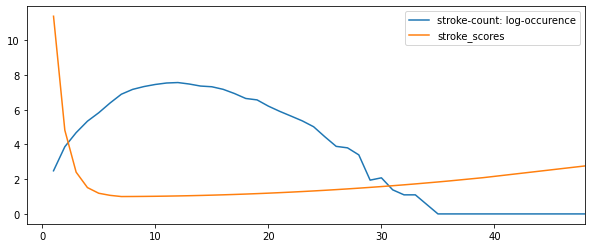

In [24]:
fig = plt.figure(figsize=(10,4))
ax = fig.gca()
stroke_count_occurence = df.Strokes.value_counts().sort_index()
stroke_count_occurence.map(np.log).rename('stroke-count: log-occurence').plot(ax=ax)
stroke_count = stroke_count_occurence.index.to_series()
stroke_count.map(scorefunc).rename('stroke_scores').plot(ax=ax)
max_strokes = df.Strokes.max()
ax.set_xlim(right=max_strokes)
# ax.set_yscale('log')
ax.legend()
plt.show()

#### let the buds sprout

###### setup

In [25]:
kdb = make_kids_db()

In [26]:
def look_at_next(T1):
    T1_keys = list(T1.keys())  # complete list of keys from previous state
    t1 = {} # building the new state
    for a in T1_keys:
        t1[a] = {} # initialize a dict for each of previous state's keys
        for b in (i for i in get_kids(a) + get_parents(a) if i): 
            t1[a][b] = (T1[a][0] + [b],
                        T1[a][1] + score(b))
    return t1

In [27]:
def take_next_step(T1, t1):
    for c in t1:
        for d in t1[c]:
            try:
                T1[d]
            except KeyError as e:
                T1[d] = t1[c][d]
            if T1[d][1] > t1[c][d][1]:
                T1[d] = t1[c][d]
    return T1

###### start

In [41]:
# starts = ('祥','愛') # [祥, 羊, 鮮, 魚, 鱫, 愛]
# starts = ('潘','祥')  # [潘, 番, 翻, 羽, 翔, 羊, 祥]
# starts = ('潘', '愛') # [潘, 番, 鐇, 金, 鑀, 愛]
# starts = ('芒', '愛') # [芒, 恾, 忄, 懓, 愛]
# starts = ('芒', '祥') # [芒, 硭, 石, 祏, 礻, 祥]
starts = ('蓉', '榮')
s = starts
T1 = {s[0]: ([s[0]], 0)}
T2 = {s[1]: ([s[1]], 0)}

In [44]:
t1 = look_at_next(T1)
t2 = look_at_next(T2)
T1 = take_next_step(T1, t1)
T2 = take_next_step(T2, t2)
print((len(T1), len(T2)))
intersection = set(T1).intersection(set(T2))
print(len(intersection))

(2448, 6718)
795


In [45]:
scoring = {c: (T1[c][1] + T2[c][1]) for c in intersection}
scoring = pd.Series(scoring, name='scoring').to_frame()
path = {c: (T1[c][0] + T2[c][0][:-1][::-1]) for c in intersection}
path = pd.Series(path, name='path').to_frame()
path_scores = path.join(scoring).sort_values('scoring', ascending=True)

In [46]:
path_scores.head(10)

,path,scoring
容,"[蓉, 容, 榕, 木, 榮]",4.613250
榕,"[蓉, 容, 榕, 木, 榮]",4.661249
木,"[蓉, 容, 榕, 木, 榮]",5.114483
金,"[蓉, 容, 鎔, 金, 鑅, 榮]",5.424015
鎔,"[蓉, 容, 鎔, 金, 鑅, 榮]",5.564015
熔,"[蓉, 容, 熔, 火, 炏, 榮]",5.665252
穃,"[蓉, 容, 穃, 禾, 木, 榮]",5.885531
荣,"[蓉, 艹, 荣, 木, 榮]",5.941234
禾,"[蓉, 容, 穃, 禾, 木, 榮]",5.994811
火,"[蓉, 容, 熔, 火, 炏, 榮]",6.118486


In [ ]:
# t1 structure:
    # {end: {
    #         bud: ([start, ..., end, bud], total_score),
    #         bud: ([start, ..., end, bud], total_score)
    #     }
    #  end: {
    #         bud...
    #     }
    # }

In [ ]:
T1_keys = list(T1.keys())  # complete list of keys from previous state
t1 = {} # building the new state
for a in T1_keys:
    t1[a] = {} # initialize a dict for each of previous state's keys
    for b in (i for i in get_kids(a) + get_parents(a) if i): 
        t1[a][b] = (T1[a][0] + [b],
                    T1[a][1] + score(b))
t1